# Fisher Information Matrix: Sensitivity and Robustness Analysis

In this notebook, we investigate the expected sensitivity of our model to changes in its parameters around the MAP estimates (as in [Sensitivity, robustness, and identifiability in stochastic chemical kinetics models](https://www.pnas.org/content/108/21/8645/tab-figures-data) by Komorowski et al), and analyse its robustness to simultaneous changes in parameters. This is done by computing the Fisher Information matrices for both the deterministic (ie population size $N\rightarrow \infty$) and stochastic model and comparing their properties. 

The model used for generating data and defining the observation process can be found in more detail in ex-mixed_inits. 

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 
from scipy.linalg import eig
import scipy
from matplotlib import ticker, cm

rcparams = {}
rcparams['text.usetex'] = True
rcparams['axes.linewidth'] = 0.5
rcparams['font.family'] = 'sans-serif'
rcparams['font.size'] = 22

## 1) Generate a trajectory from the SEIR model
We generate a test trajectory on a population with two ages groups.

In [3]:
# correct params
N = 1e6 
M = 2 

beta  = 0.02        # infection rate
gIa   = 1./7        # recovery rate of asymptomatic infectives
gIs   = 1./7        # recovery rate of asymptomatic infectives
gE    = 0.1         # exposed to infected rate
fsa   = 1         # the self-isolation parameter (assumed to be known)
alpha = np.array([0.5, 0.2])       # fraction of asymptomatic infectives

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

def contactMatrix(t):
    return C 

Tf = 300
Nf = Tf+1

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa}
true_parameters = parameters

S0 = Ni
Ia0 = np.zeros((M)) +1
Ia0[1] += 2
S0[1] -= 2

Is0 = np.zeros((M))
E0 = np.zeros((M))

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEIR(parameters, M, Ni)
data = sto_model.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nf, method='tau_leaping')

## 2) Define and apply an observation process

Only observe $N-R$ and $I_\mathrm{s}$ for each age group

In [4]:
# load the data and rescale to intensive variables 
N_start = 50 # decide based upon when the infected hits ~100 
Tf_inference = 50 
Nf_inference = Tf_inference + 1


x = data['X'].astype('float')
x = x[N_start:N_start+Nf_inference]
steps = 4 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SEIR(parameters, M, Ni)


# make a fltr to get N-R and Is for each age class 
fltr=np.kron([[1, 1, 1, 1], [0, 0, 0, 1]], np.identity(M))
obs=np.einsum('ij,kj->ki', fltr, x)
x0=x[0]

# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
estimator.set_det_model(parameters)
estimator.set_contact_matrix(contactMatrix)
time_points = np.linspace(0, Tf_inference, Nf_inference)
xm = estimator.integrate(x0, 0, Tf_inference, Nf_inference)



## 3) Set up the inference 

In [5]:
# Set up init priors
init_priors = {} 

# Use lin mode for E 
zero_state = np.zeros((4*M))
zero_state[:M] = Ni 
dev = x0 - zero_state 
c = np.linalg.norm(dev, ord=1) # coefficient of the linear mode 
init_priors['lin_mode_coeff'] = {
        'mean':c, 
        'std':c, 
        'bounds': [1, c*10], 
        'fltr': np.repeat([False, True, False, False], M) # Infer E with lin modes
    }

# But guess Ia0 independently 
eps = 1e-3 
init_priors['independent'] = {
    'mean': x0[4:6], # in practice, would use the lin mode as initial guess 
    'std': x0[4:6]/2, 
    'bounds': [[eps, 1e4] for i in range(M)], 
    'fltr': np.repeat([False, False, True, False], M) # Infer Ia with this 
} 

In [6]:
# make parameter guesses and set up bounds for each parameter 
eps = 1e-3
param_priors = {
    'alpha':{
        'mean': [0.5, 0.2], 
        'infer_scale': True, 
        'scale_factor_std': 1,
        'scale_factor_bounds': [eps, 10]
    }, 
    'beta':{
        'mean': 0.03, 
        'std': 0.02, 
        'bounds': [eps, 1]
    }, 
    'gE':{
        'mean': 0.11, 
        'std': 0.05, 
        'bounds': [eps, 0.2]
    }
}


# optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  

start_time = time.time()
res = estimator.latent_infer_parameters(obs, fltr, Tf_inference, contactMatrix, param_priors, init_priors, 
                                           tangent=True, verbose=False, enable_global=False, 
                                           cma_population=32, global_max_iter=100, global_atol=10, 
                                           local_max_iter=200, ftol=ftol)
end_time = time.time()
print(end_time - start_time)
print(res)

2.533594846725464
{'map_params_dict': {'alpha': array([0.5020162 , 0.20080648]), 'beta': 0.023850202935289125, 'gIa': array([0.14285714, 0.14285714]), 'gIs': array([0.14285714, 0.14285714]), 'gE': 0.07176714305050173, 'fsa': array([1., 1.])}, 'map_x0': array([2.49749939e+05, 7.49734091e+05, 1.40002938e+02, 1.40003022e+02,
       2.70582960e+01, 7.90560374e+00, 1.40000000e+01, 2.30000000e+01]), 'flat_map': array([1.00403240e+00, 2.38502029e-02, 7.17671431e-02, 8.82785412e+02,
       2.70582960e+01, 7.90560374e+00]), '-logp': 722.135612520586, 'param_keys': ['alpha', 'beta', 'gE'], 'param_guess_range': [0, 1, 2], 'is_scale_parameter': [True, False, False], 'param_length': 3, 'scaled_param_guesses': [[0.5, 0.2]], 'init_flags': [True, True], 'init_fltrs': array([[False, False,  True,  True, False, False, False, False],
       [False, False, False, False,  True,  True, False, False]]), 's': array([0.83255461, 0.60640315, 0.43337752, 0.83255461, 0.47238073,
       0.47238073]), 'scale': arra

## 4) Sensitivity analysis

Compute the Fisher Information matrices for both the deterministic and the stochastic models and take a look at their eigenvalues/whether they are positive definite. Small values correspond to the expected non-identifiability of the parameter in an experiment, ie it will be hard to estimate. Proceed to compute the sensitivity measure defined by Komorowski et al (see description above). 

A larger value at position $i$ means that the model is expected to be more sensitive to changes in the parameter $i$ in res['flat_map'] around the MAP estimate. If a particular value is small for the deterministic model, but large for the stochastic model, this parameter is expected to control stochastic effects in a system

In [7]:
# stochastic FIM
eps = None
FIM_sto = estimator.FIM(obs, fltr, Tf_inference, contactMatrix,
                   map_dict=res, tangent=True, eps=eps)

# check if FIM_sto is positive definite
print(np.all(np.linalg.eigvals(FIM_sto) > 0))

evals_sto, evecs_sto = eig(FIM_sto)

print(evals_sto)

eps-vector used for differentiation:  [1.49011612e-08 1.86264515e-09 3.72529030e-09 3.37174788e-07
 5.96046448e-08 2.98023224e-08]
False
[ 2.14357009e+07+0.j  1.26224991e+04+0.j  2.30068541e+03+0.j
  3.19558006e-02+0.j  1.82386392e-02+0.j -2.51942053e-07+0.j]


In [9]:
Tj_sto = estimator.sensitivity(FIM_sto, rtol=1e-6, atol=1e-5)

print(Tj_sto)

Relative size: Eigenvalue  3  is less than  1e-06  times the largest eigenvalue and might not be identifiable.

Relative size: Eigenvalue  4  is less than  1e-06  times the largest eigenvalue and might not be identifiable.

Relative size + negative: Eigenvalue  5  is less than  1e-06  times the largest eigenvalue AND NEGATIVE and might not be identifiable.
Please ensure that the step size eps in the FIM computation is appropriate.
CAUTION: Proceed with slightly modified FIM, shifting the small negative eigenvalue  5  into the positives. Thereby, all other eigenvalues and therefore sensitivities will be shifted slightly. This will have a larger relative effect on the above-mentioned small eigenvalues/sensitivities.

[5.82003167e-04 7.93772506e-04 9.98624221e-01 5.86250494e-10
 1.39545696e-09 1.49467012e-09]


In [10]:
# deterministic FIM
FIM_det = estimator.FIM_det(obs, fltr, Tf_inference, contactMatrix,
                   map_dict=res,eps=eps, measurement_error=1e-2)

# check if FIM_det is positive definite
print(np.all(np.linalg.eigvals(FIM_det) > 0))

evals_det, evecs_det = eig(FIM_det)

print(evals_det)

eps-vector used for differentiation:  [1.49011612e-08 1.86264515e-09 3.72529030e-09 3.37174788e-07
 5.96046448e-08 2.98023224e-08]
True
[5.48192021e+16+0.j 1.47690542e+12+0.j 9.66187060e+10+0.j
 1.29877384e+06+0.j 5.85742176e+04+0.j 1.67116059e+02+0.j]


In [11]:
Tj_det = estimator.sensitivity(FIM_det, rtol=1e-6, atol=1e-5)

print(Tj_det)

Relative size: Eigenvalue  3  is less than  1e-06  times the largest eigenvalue and might not be identifiable.

Relative size: Eigenvalue  4  is less than  1e-06  times the largest eigenvalue and might not be identifiable.

Relative size: Eigenvalue  5  is less than  1e-06  times the largest eigenvalue and might not be identifiable.

[2.78214469e-05 6.97227344e-04 9.99271931e-01 3.01947331e-06
 2.26735066e-10 4.47547476e-11]


## 5) Robustness analysis

Compare the expected correlations of the deterministic and the stochastic model. This can serve as a measure of how robust the model is around the MAP estimates to simultaneous changes in parameters. Regions within such covariance ellipses are called neutral spaces.

In [12]:
ff, ss, Z_sto, Z_det = estimator.robustness(FIM=FIM_sto, FIM_det=FIM_det,
                map_dict=res, param_pos_1=0,
                param_pos_2=1, range_1=0.5,
                range_2=0.01, resolution_1=int(20))

Plot the expected correlations of the inferred $\alpha$ scale-parameter and $\beta$. The heat map represents the stochastic model, the thick dashed contour lines are generated by the deterministic model. Clearly, stochasticity induces extra correlations.

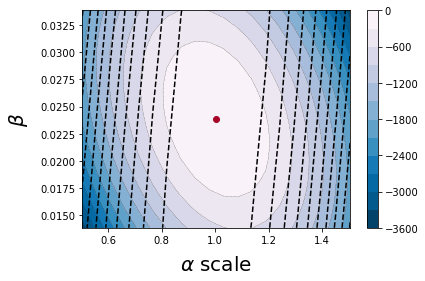

In [14]:
cmap = plt.cm.PuBu_r
levels=11
colors='black'

c = plt.contourf(ff, ss, Z_sto, cmap=cmap, levels=levels)
plt.contour(ff, ss, Z_sto, colors='black', levels=levels, linewidths=0.25)
plt.contour(ff, ss, Z_det, colors=colors, levels=levels)
plt.plot(res['flat_map'][0], res['flat_map'][1], 'o',
            color="#A60628", markersize=6)
plt.colorbar(c)
plt.xlabel(r'$\alpha$ scale', fontsize=20, labelpad=10)
plt.ylabel(r'$\beta$', fontsize=20, labelpad=10)
plt.show()